In [3]:
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from pystacknet.pystacknet import StackNetClassifier

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [58]:
# Read in the dataset as a dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((891, 12), (418, 11))

In [59]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
# Split features and labels
train_labels = train['Survived'].reset_index(drop=True)
train_features = train.drop(['Survived'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(1309, 11)

In [61]:
all_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
all_features.drop(['PassengerId', 'Name'], axis = 1, inplace=True)

In [63]:
all_features.isnull().sum()

Pclass         0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [77]:
all_features.drop(['Ticket'], axis = 1, inplace=True)

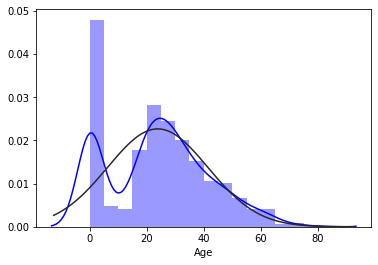

In [70]:
#Check the target distribution 
sns.distplot(all_features['Age'] , fit=norm, color="b");

plt.show()

In [66]:
all_features['Age'] = all_features['Age'].fillna(0)

In [67]:
all_features['Embarked'] = all_features['Embarked'].fillna(all_features['Embarked'].mode())

In [68]:
all_features['Fare'] = all_features['Fare'].fillna(all_features['Fare'].mean())

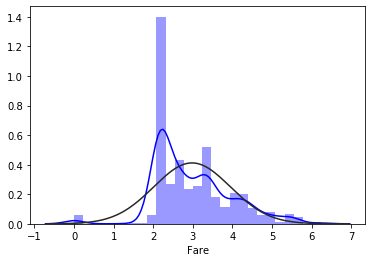

In [69]:
#Check the target distribution 
sns.distplot(np.log1p(all_features['Fare']) , fit=norm, color="b");

plt.show()

In [71]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        if i in ['Pclass', 'SibSp', 'Parch']: # categorical features with numeric values
            pass
        else:
            numeric.append(i)

In [72]:
numeric

['Age', 'Fare']

In [75]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 0 numerical features with Skew > 0.5 :


Fare    0.289424
Age     0.257037
dtype: float64

In [74]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [82]:
# One hot encoding
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(1309, 12)

In [83]:
all_features.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,1.973969,0,1,0,0,1,0,0,1
1,38.0,1,0,3.744493,1,0,1,0,0,1,0,0
2,26.0,0,0,2.042508,1,0,0,0,1,0,0,1
3,35.0,1,0,3.522093,1,0,0,0,1,1,0,0
4,35.0,0,0,2.054594,0,1,0,0,1,0,0,1


In [81]:
# Some of the non-numeric predictors might be stored as numbers; convert them into strings
all_features['Pclass'] = all_features['Pclass'].astype(str)

In [84]:
# Recreate training and test sets
X = all_features.iloc[:len(train_labels), :]

X_test = all_features.iloc[len(train_labels):, :]

X.shape, train_labels.shape, X_test.shape

((891, 12), (891,), (418, 12))

In [85]:
# Setup cross validation folds
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [86]:
def cv_accuracy(model, X=X):
    accuracy = cross_val_score(model, X, train_labels, scoring="accuracy", cv=kf)
    return (accuracy)

In [88]:
# Light Gradient Boosting Classifier
lightgbm = LGBMClassifier(num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBClassifier(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Support Vector Regressor
svc = make_pipeline(RobustScaler(), SVC(C= 20, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingClassifier(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestClassifier(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [89]:
scores = {}

score = cv_accuracy(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.8260 (0.0436)


In [90]:
score = cv_accuracy(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.8339 (0.0389)


In [91]:
score = cv_accuracy(svc)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svc'] = (score.mean(), score.std())

SVR: 0.7867 (0.0508)


In [92]:
score = cv_accuracy(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.8294 (0.0402)


In [1]:
score = cv_accuracy(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

NameError: name 'cv_accuracy' is not defined

In [96]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost


In [99]:
# Read in sample_submission dataframe
submission = pd.read_csv("gender_submission.csv")
submission.shape

(418, 2)

In [100]:
# Append predictions from blended models
submission.iloc[:,1] = xgb_model_full_data.predict(X_test)

In [101]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [103]:
submission.set_index('PassengerId').to_csv('submission.csv')